In [1]:
import sys
sys.path.append('..')

from moabb.datasets import BI2013a
from src.models.svm import SVM
import torch
import mne, logging
mne.set_log_level("WARNING")
logging.getLogger("mne").setLevel(logging.WARNING)
import numpy as np
from pathlib import Path
ds = BI2013a(NonAdaptive=True, Adaptive=True, Training=True, Online=True)
ds.download()
ds.subject_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [2]:
raws = ds.get_data(subjects=list(range(1, 5)))
raws

{1: {'0': {'0': <RawArray | 17 x 159232 (311.0 s), ~20.7 MiB, data loaded>,
   '1': <RawArray | 17 x 125184 (244.5 s), ~16.3 MiB, data loaded>,
   '2': <RawArray | 17 x 139552 (272.6 s), ~18.1 MiB, data loaded>,
   '3': <RawArray | 17 x 144384 (282.0 s), ~18.8 MiB, data loaded>},
  '1': {'0': <RawArray | 17 x 132896 (259.6 s), ~17.3 MiB, data loaded>,
   '1': <RawArray | 17 x 104640 (204.4 s), ~13.6 MiB, data loaded>,
   '2': <RawArray | 17 x 138784 (271.1 s), ~18.0 MiB, data loaded>,
   '3': <RawArray | 17 x 106528 (208.1 s), ~13.8 MiB, data loaded>},
  '2': {'0': <RawArray | 17 x 131776 (257.4 s), ~17.1 MiB, data loaded>,
   '1': <RawArray | 17 x 101184 (197.6 s), ~13.1 MiB, data loaded>,
   '2': <RawArray | 17 x 133024 (259.8 s), ~17.3 MiB, data loaded>,
   '3': <RawArray | 17 x 137984 (269.5 s), ~17.9 MiB, data loaded>},
  '3': {'0': <RawArray | 17 x 146592 (286.3 s), ~19.0 MiB, data loaded>,
   '1': <RawArray | 17 x 97504 (190.4 s), ~12.7 MiB, data loaded>,
   '2': <RawArray | 17 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rng = np.random.default_rng(42)

In [4]:
subjects = ds.subject_list
rng.shuffle(subjects)

n = len(subjects)
train_subj = subjects[: int(0.7*n)]
val_subj   = subjects[int(0.7*n): int(0.85*n)]
test_subj  = subjects[int(0.85*n):]
print(f"{len(train_subj)=}, {len(val_subj)=}, {len(test_subj)=}")

len(train_subj)=16, len(val_subj)=4, len(test_subj)=4


In [5]:
def infer_target_ids(event_id: dict):
    lower = {k.lower(): v for k, v in event_id.items()}
    tgt_candidates = [k for k in lower if "target" in k and "non" not in k]
    nontgt_candidates = [k for k in lower if "non" in k and "target" in k]
    if tgt_candidates and nontgt_candidates:
        return lower[tgt_candidates[0]], lower[nontgt_candidates[0]]
    vals = sorted(set(event_id.values()))
    if len(vals) >= 2:
        return vals[-1], vals[0]
    raise RuntimeError(f"Cannot infer target IDs from {event_id}")


In [6]:
def preprocess_raw(raw: mne.io.BaseRaw, l_freq=1.0, h_freq=20.0, sfreq=128):
    raw = raw.copy().load_data()
    raw.pick_types(eeg=True, eog=False)
    raw.filter(l_freq, h_freq, verbose=False)
    raw.set_eeg_reference("average", projection=False, verbose=False)
    raw.resample(sfreq, verbose=False)
    return raw

def epoch_and_features(raw: mne.io.BaseRaw,
                       tmin=-0.2, tmax=0.8, baseline=(None, 0),
                       decim=2):
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    tgt, non = infer_target_ids(event_id)
    epochs = mne.Epochs(
        raw, events, event_id={"Target": tgt, "NonTarget": non},
        tmin=tmin, tmax=tmax, baseline=baseline, preload=True, verbose=False
    )
    X = epochs.get_data()[:, :, ::decim]          # (trials, ch, time//decim)
    y = (epochs.events[:, 2] == tgt).astype(np.int64)
    # Flatten (trials, ch*time)
    X = X.reshape(X.shape[0], -1).astype("float32")
    return X, y

def zscore_batch(X, eps=1e-8):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    return (X - mu) / (sd + eps)


In [7]:
def to_pm1(y01: np.ndarray) -> np.ndarray:
    return np.where(y01 > 0, 1.0, -1.0).astype("float32")

class RunningStandardizer:
    def __init__(self, eps=1e-8):
        self.n = 0
        self.sum = None
        self.sumsq = None
        self.eps = eps
    def partial_fit(self, X):
        X = np.asarray(X, np.float32)
        if self.sum is None:
            self.sum = X.sum(axis=0)
            self.sumsq = (X * X).sum(axis=0)
            self.n = X.shape[0]
        else:
            self.sum += X.sum(axis=0)
            self.sumsq += (X * X).sum(axis=0)
            self.n += X.shape[0]
        return self
    def transform(self, X):
        if self.n == 0:
            return X
        mean = self.sum / self.n
        var = self.sumsq / self.n - mean * mean
        std = np.sqrt(np.maximum(var, 0.0)) + self.eps
        return (X - mean) / std

def iter_subject_batches(ds: BI2013a, subject_ids):
    nested = ds.get_data(subject_ids)  # {subj: {session: {run: Raw}}}
    for subj, sessions in nested.items():
        for sess, runs in sessions.items():
            for run_name, raw in runs.items():
                raw_p = preprocess_raw(raw)
                X, y01 = epoch_and_features(raw_p)
                if len(y01) == 0:
                    continue
                yield subj, sess, run_name, X, y01

In [8]:
def decision_function(svm, Xt: torch.Tensor) -> torch.Tensor:
    # raw margins: X @ w + b  (no sigmoid!)
    return Xt @ svm.weights + svm.bias  # (N,)

def best_threshold_by_f1(scores: torch.Tensor, y_true01: torch.Tensor):
    s = scores.detach().cpu().numpy()
    y = y_true01.detach().cpu().numpy().astype(int)
    qs = np.linspace(0.01, 0.99, 99)
    ths = np.quantile(s, qs)
    best_t, best_f1 = 0.0, -1.0
    for t in ths:
        pred = (s > t).astype(int)
        tp = ((pred==1)&(y==1)).sum()
        fp = ((pred==1)&(y==0)).sum()
        fn = ((pred==0)&(y==1)).sum()
        p = tp/(tp+fp+1e-9); r = tp/(tp+fn+1e-9)
        f1 = 2*p*r/(p+r+1e-9)
        if f1 > best_f1:
            best_t, best_f1 = float(t), float(f1)
    return best_t, best_f1

def simple_metrics(pred01: torch.Tensor, y01: torch.Tensor):
    y = y01.to(torch.int32); p = pred01.to(torch.int32)
    tp = int(((p==1)&(y==1)).sum().item())
    fp = int(((p==1)&(y==0)).sum().item())
    tn = int(((p==0)&(y==0)).sum().item())
    fn = int(((p==0)&(y==1)).sum().item())
    acc = (tp+tn)/max(tp+tn+fp+fn,1)
    prec = tp/max(tp+fp,1e-9); rec = tp/max(tp+fn,1e-9)
    f1 = 2*prec*rec/max(prec+rec,1e-9)
    return {"tp":tp,"fp":fp,"tn":tn,"fn":fn,"accuracy":acc,"precision":prec,"recall":rec,"f1":f1}

In [9]:
# === Split subjects ===
ds = BI2013a()
subjects = ds.subject_list
rng = np.random.default_rng(42)
rng.shuffle(subjects)

n = len(subjects)
train_subj = subjects[: int(0.7 * n)]
val_subj   = subjects[int(0.7 * n): int(0.85 * n)]
test_subj  = subjects[int(0.85 * n):]
print(f"train={len(train_subj)}, val={len(val_subj)}, test={len(test_subj)}")

# === Model & scaler ===
svm = SVM(
    learning_rate=1e-3,    # try 5e-4 or 1e-4 if unstable
    max_epochs=1,          # per-chunk epochs (we loop passes below)
    batch_size=1024,
    C=1.0,
    device=device
)
scaler = RunningStandardizer()

# --- helper to count total train trials for progress ---
import numpy as np, mne
from tqdm import tqdm

def count_train_trials(ds, subject_ids):
    total = 0
    nested = ds.get_data(subject_ids)
    for subj, sessions in nested.items():
        for sess, runs in sessions.items():
            for run_name, raw in runs.items():
                events, event_id = mne.events_from_annotations(raw, verbose=False)
                try:
                    tgt, non = infer_target_ids(event_id)
                except Exception:
                    continue
                mask = (events[:, 2] == tgt) | (events[:, 2] == non)
                total += int(mask.sum())
    return total

# === TRAIN (streaming, warm-start expected in your SVM.fit) ===
passes = 5
total_trials = count_train_trials(ds, train_subj)
pbar = tqdm(total=passes * total_trials, desc="Training trials", unit="trial")

freeze_scaler = False
for pass_id in range(passes):
    # simple LR decay to help convergence stability
    if pass_id in (1, 3):
        svm.learning_rate *= 0.5

    for *_hdr, Xb, yb01 in iter_subject_batches(ds, train_subj):
        if not freeze_scaler:
            scaler.partial_fit(Xb)
        Xb = scaler.transform(Xb)
        yb_pm1 = to_pm1(yb01)  # {-1,+1} for hinge

        Xb_t = torch.from_numpy(Xb).to(device)
        yb_t = torch.from_numpy(yb_pm1).to(device)
        svm.fit(Xb_t, yb_t)    # must NOT re-init weights inside

        # progress
        pbar.update(len(yb01))
        pbar.set_postfix(
            pass_=f"{pass_id+1}/{passes}",
            lr=f"{svm.learning_rate:.1e}",
            done=f"{100*pbar.n/pbar.total:.1f}%"
        )

    # freeze scaler stats after first full sweep
    if pass_id == 0:
        freeze_scaler = True

pbar.close()

# === VALIDATION ===
val_X, val_y01 = [], []
for *_hdr, Xb, yb01 in iter_subject_batches(ds, val_subj):
    val_X.append(scaler.transform(Xb))
    val_y01.append(yb01)

if val_X:
    Xv = torch.from_numpy(np.vstack(val_X)).to(device)
    yv = torch.from_numpy(np.hstack(val_y01).astype("float32")).to(device)  # 0/1 for metrics
    print("VAL:", svm.score(Xv, yv))

# === TEST ===
test_X, test_y01 = [], []
for *_hdr, Xb, yb01 in iter_subject_batches(ds, test_subj):
    test_X.append(scaler.transform(Xb))
    test_y01.append(yb01)

Xt = torch.from_numpy(np.vstack(test_X)).to(device)
yt = torch.from_numpy(np.hstack(test_y01).astype("float32")).to(device)
print("TEST:", svm.score(Xt, yt))


# ---- calibrate threshold on VAL ----
scores_val = decision_function(svm, Xv)   # margins
t_star, f1_star = best_threshold_by_f1(scores_val, yv)
print(f"Chosen threshold t*={t_star:.4f} (VAL F1={f1_star:.3f})")

# evaluate VAL with t*
pred_val = (scores_val > t_star).float()
print("VAL@t*:", simple_metrics(pred_val, yv))

# ---- evaluate TEST with the same t* ----
scores_test = decision_function(svm, Xt)
pred_test = (scores_test > t_star).float()
print("TEST@t*:", simple_metrics(pred_test, yt))


train=16, val=4, test=4


Training trials:   1%|          | 960/105600 [00:07<11:49, 147.50trial/s, done=0.9%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.1255
Epoch 1/1, loss=2.1258


Training trials:   2%|▏         | 1920/105600 [00:08<04:12, 410.99trial/s, done=1.8%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.1219
Epoch 1/1, loss=2.1221


Training trials:   3%|▎         | 2880/105600 [00:08<02:47, 611.53trial/s, done=2.7%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0913
Epoch 1/1, loss=2.0953


Training trials:   4%|▎         | 3840/105600 [00:08<01:15, 1351.30trial/s, done=3.6%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.1127
Epoch 1/1, loss=2.1032


Training trials:   5%|▍         | 4800/105600 [00:08<00:51, 1964.57trial/s, done=4.5%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.1029
Epoch 1/1, loss=2.0990


Training trials:   5%|▌         | 5760/105600 [00:09<00:38, 2619.42trial/s, done=5.5%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.1074
Epoch 1/1, loss=2.0934


Training trials:   6%|▋         | 6720/105600 [00:09<00:32, 3049.27trial/s, done=6.4%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0930
Epoch 1/1, loss=2.0873


Training trials:   7%|▋         | 7680/105600 [00:09<00:29, 3358.32trial/s, done=7.3%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0900
Epoch 1/1, loss=2.0761


Training trials:   8%|▊         | 8640/105600 [00:09<00:26, 3661.44trial/s, done=8.2%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0918
Epoch 1/1, loss=2.0868


Training trials:   9%|▉         | 9600/105600 [00:10<00:25, 3824.34trial/s, done=9.1%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0969
Epoch 1/1, loss=2.0888


Training trials:  10%|█         | 10560/105600 [00:10<00:24, 3958.08trial/s, done=10.0%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0904
Epoch 1/1, loss=2.0957


Training trials:  11%|█         | 11520/105600 [00:10<00:24, 3779.15trial/s, done=10.9%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0907
Epoch 1/1, loss=2.1021


Training trials:  12%|█▏        | 12480/105600 [00:10<00:23, 3946.03trial/s, done=11.8%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0894
Epoch 1/1, loss=1.9848


Training trials:  13%|█▎        | 13440/105600 [00:11<00:22, 4040.60trial/s, done=12.7%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=1.8569
Epoch 1/1, loss=1.8816


Training trials:  14%|█▎        | 14400/105600 [00:11<00:21, 4236.23trial/s, done=13.6%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=1.8160
Epoch 1/1, loss=1.8315


Training trials:  15%|█▍        | 15360/105600 [00:11<00:19, 4521.95trial/s, done=14.5%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=1.8569
Epoch 1/1, loss=1.8806


Training trials:  15%|█▌        | 16320/105600 [00:11<00:20, 4360.22trial/s, done=15.5%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=1.8663
Epoch 1/1, loss=2.0181


Training trials:  16%|█▋        | 17280/105600 [00:11<00:20, 4218.92trial/s, done=16.4%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0667
Epoch 1/1, loss=2.0216


Training trials:  17%|█▋        | 18240/105600 [00:12<00:21, 4060.04trial/s, done=17.3%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=1.9876
Epoch 1/1, loss=2.0029


Training trials:  18%|█▊        | 19200/105600 [00:12<00:23, 3728.06trial/s, done=18.2%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0010
Epoch 1/1, loss=2.0205


Training trials:  19%|█▉        | 20160/105600 [00:12<00:22, 3725.35trial/s, done=19.1%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=1.9896
Epoch 1/1, loss=2.0116


Training trials:  20%|██        | 21120/105600 [00:12<00:22, 3771.04trial/s, done=20.0%, lr=1.0e-03, pass_=1/5]

Epoch 1/1, loss=2.0319
Epoch 1/1, loss=1.9684


Training trials:  21%|██        | 22080/105600 [00:20<04:41, 296.39trial/s, done=20.9%, lr=5.0e-04, pass_=2/5] 

Epoch 1/1, loss=2.0106
Epoch 1/1, loss=2.0103


Training trials:  22%|██▏       | 23040/105600 [00:20<02:26, 562.52trial/s, done=21.8%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0051
Epoch 1/1, loss=2.0241


Training trials:  23%|██▎       | 24000/105600 [00:20<01:47, 761.90trial/s, done=22.7%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9204
Epoch 1/1, loss=1.9565


Training trials:  24%|██▎       | 24960/105600 [00:20<00:54, 1489.33trial/s, done=23.6%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9945
Epoch 1/1, loss=1.9848


Training trials:  25%|██▍       | 25920/105600 [00:21<00:38, 2068.94trial/s, done=24.5%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9724
Epoch 1/1, loss=1.9733


Training trials:  25%|██▌       | 26880/105600 [00:21<00:29, 2664.26trial/s, done=25.5%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0382
Epoch 1/1, loss=1.9897


Training trials:  26%|██▋       | 27840/105600 [00:21<00:24, 3199.83trial/s, done=26.4%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0034
Epoch 1/1, loss=1.9800


Training trials:  27%|██▋       | 28800/105600 [00:21<00:21, 3601.56trial/s, done=27.3%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0039
Epoch 1/1, loss=1.9893


Training trials:  28%|██▊       | 29760/105600 [00:22<00:20, 3717.84trial/s, done=28.2%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0024
Epoch 1/1, loss=1.9988


Training trials:  29%|██▉       | 30720/105600 [00:22<00:19, 3890.72trial/s, done=29.1%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0315
Epoch 1/1, loss=2.0206


Training trials:  30%|███       | 31680/105600 [00:22<00:19, 3887.33trial/s, done=30.0%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0190
Epoch 1/1, loss=2.0376


Training trials:  31%|███       | 32640/105600 [00:22<00:18, 3958.99trial/s, done=30.9%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0369
Epoch 1/1, loss=2.0694


Training trials:  32%|███▏      | 33600/105600 [00:23<00:18, 3937.55trial/s, done=31.8%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0511
Epoch 1/1, loss=1.8515


Training trials:  33%|███▎      | 34560/105600 [00:23<00:17, 3947.77trial/s, done=32.7%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.6968
Epoch 1/1, loss=1.7732


Training trials:  34%|███▎      | 35520/105600 [00:23<00:16, 4194.91trial/s, done=33.6%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.7188
Epoch 1/1, loss=1.7297


Training trials:  35%|███▍      | 36480/105600 [00:23<00:16, 4163.15trial/s, done=34.5%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.7616
Epoch 1/1, loss=1.8023


Training trials:  35%|███▌      | 37440/105600 [00:24<00:15, 4289.72trial/s, done=35.5%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.7925
Epoch 1/1, loss=1.9572


Training trials:  36%|███▋      | 38400/105600 [00:24<00:15, 4220.26trial/s, done=36.4%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=2.0501
Epoch 1/1, loss=1.9562


Training trials:  37%|███▋      | 39360/105600 [00:24<00:15, 4164.82trial/s, done=37.3%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9196
Epoch 1/1, loss=1.9474


Training trials:  38%|███▊      | 40320/105600 [00:24<00:15, 4214.63trial/s, done=38.2%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9475
Epoch 1/1, loss=1.9662


Training trials:  39%|███▉      | 41280/105600 [00:25<00:15, 4134.50trial/s, done=39.1%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9307
Epoch 1/1, loss=1.9692


Training trials:  40%|████      | 42240/105600 [00:25<00:15, 4081.11trial/s, done=40.0%, lr=5.0e-04, pass_=2/5]

Epoch 1/1, loss=1.9991
Epoch 1/1, loss=1.9105


Training trials:  41%|████      | 43200/105600 [00:32<03:23, 306.60trial/s, done=40.9%, lr=5.0e-04, pass_=3/5] 

Epoch 1/1, loss=1.9612
Epoch 1/1, loss=1.9595


Training trials:  42%|████▏     | 44160/105600 [00:32<01:46, 579.18trial/s, done=41.8%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9592
Epoch 1/1, loss=1.9871


Training trials:  43%|████▎     | 45120/105600 [00:32<00:58, 1039.70trial/s, done=42.7%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.8704
Epoch 1/1, loss=1.9207


Training trials:  44%|████▎     | 46080/105600 [00:33<00:35, 1672.19trial/s, done=43.6%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9352
Epoch 1/1, loss=1.9350


Training trials:  45%|████▍     | 47040/105600 [00:33<00:24, 2368.55trial/s, done=44.5%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9189
Epoch 1/1, loss=1.9178


Training trials:  45%|████▌     | 48000/105600 [00:33<00:19, 3024.64trial/s, done=45.5%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=2.0019
Epoch 1/1, loss=1.9381


Training trials:  46%|████▋     | 48960/105600 [00:33<00:16, 3369.86trial/s, done=46.4%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9565
Epoch 1/1, loss=1.9272


Training trials:  47%|████▋     | 49920/105600 [00:34<00:15, 3638.61trial/s, done=47.3%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9610
Epoch 1/1, loss=1.9434


Training trials:  48%|████▊     | 50880/105600 [00:34<00:14, 3832.41trial/s, done=48.2%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9604
Epoch 1/1, loss=1.9539


Training trials:  49%|████▉     | 51840/105600 [00:34<00:13, 3908.78trial/s, done=49.1%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9932
Epoch 1/1, loss=1.9805


Training trials:  50%|█████     | 52800/105600 [00:34<00:13, 3937.95trial/s, done=50.0%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9816
Epoch 1/1, loss=2.0073


Training trials:  51%|█████     | 53760/105600 [00:35<00:13, 3962.37trial/s, done=50.9%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=2.0032
Epoch 1/1, loss=2.0451


Training trials:  52%|█████▏    | 54720/105600 [00:35<00:13, 3880.37trial/s, done=51.8%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=2.0229
Epoch 1/1, loss=1.7966


Training trials:  53%|█████▎    | 55680/105600 [00:35<00:12, 3930.09trial/s, done=52.7%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.6366
Epoch 1/1, loss=1.7210


Training trials:  54%|█████▎    | 56640/105600 [00:35<00:12, 3892.76trial/s, done=53.6%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.6707
Epoch 1/1, loss=1.6714


Training trials:  55%|█████▍    | 57600/105600 [00:35<00:11, 4200.74trial/s, done=54.5%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.6994
Epoch 1/1, loss=1.7497


Training trials:  55%|█████▌    | 58560/105600 [00:36<00:11, 4258.94trial/s, done=55.5%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.7344
Epoch 1/1, loss=1.9078


Training trials:  56%|█████▋    | 59520/105600 [00:36<00:10, 4276.86trial/s, done=56.4%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=2.0427
Epoch 1/1, loss=1.9094


Training trials:  57%|█████▋    | 60480/105600 [00:36<00:10, 4112.16trial/s, done=57.3%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.8702
Epoch 1/1, loss=1.9091


Training trials:  58%|█████▊    | 61440/105600 [00:36<00:10, 4172.71trial/s, done=58.2%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9043
Epoch 1/1, loss=1.9220


Training trials:  59%|█████▉    | 62400/105600 [00:37<00:10, 4144.11trial/s, done=59.1%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.8780
Epoch 1/1, loss=1.9280


Training trials:  60%|██████    | 63360/105600 [00:37<00:10, 4147.85trial/s, done=60.0%, lr=5.0e-04, pass_=3/5]

Epoch 1/1, loss=1.9660
Epoch 1/1, loss=1.8587


Training trials:  61%|██████    | 64320/105600 [00:44<02:14, 306.52trial/s, done=60.9%, lr=2.5e-04, pass_=4/5] 

Epoch 1/1, loss=1.9230
Epoch 1/1, loss=1.9132


Training trials:  62%|██████▏   | 65280/105600 [00:44<01:09, 579.11trial/s, done=61.8%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9236
Epoch 1/1, loss=1.9568


Training trials:  63%|██████▎   | 66240/105600 [00:44<00:50, 781.92trial/s, done=62.7%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.8400
Epoch 1/1, loss=1.8923


Training trials:  64%|██████▎   | 67200/105600 [00:45<00:25, 1509.46trial/s, done=63.6%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.8841
Epoch 1/1, loss=1.8976


Training trials:  65%|██████▍   | 68160/105600 [00:45<00:17, 2106.81trial/s, done=64.5%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.8754
Epoch 1/1, loss=1.8731


Training trials:  65%|██████▌   | 69120/105600 [00:45<00:13, 2744.37trial/s, done=65.5%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9706
Epoch 1/1, loss=1.8972


Training trials:  66%|██████▋   | 70080/105600 [00:45<00:10, 3234.61trial/s, done=66.4%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9207
Epoch 1/1, loss=1.8883


Training trials:  67%|██████▋   | 71040/105600 [00:46<00:09, 3642.12trial/s, done=67.3%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9294
Epoch 1/1, loss=1.9106


Training trials:  68%|██████▊   | 72000/105600 [00:46<00:08, 3736.82trial/s, done=68.2%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9318
Epoch 1/1, loss=1.9211


Training trials:  69%|██████▉   | 72960/105600 [00:46<00:08, 3865.99trial/s, done=69.1%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9651
Epoch 1/1, loss=1.9515


Training trials:  70%|███████   | 73920/105600 [00:46<00:07, 4036.60trial/s, done=70.0%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9567
Epoch 1/1, loss=1.9877


Training trials:  71%|███████   | 74880/105600 [00:47<00:07, 4019.93trial/s, done=70.9%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9808
Epoch 1/1, loss=2.0281


Training trials:  72%|███████▏  | 75840/105600 [00:47<00:07, 4083.10trial/s, done=71.8%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=2.0034
Epoch 1/1, loss=1.7609


Training trials:  73%|███████▎  | 76800/105600 [00:47<00:07, 4039.31trial/s, done=72.7%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.6047
Epoch 1/1, loss=1.6929


Training trials:  74%|███████▎  | 77760/105600 [00:47<00:06, 4221.44trial/s, done=73.6%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.6496
Epoch 1/1, loss=1.6380


Training trials:  75%|███████▍  | 78720/105600 [00:48<00:06, 4458.85trial/s, done=74.5%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.6680
Epoch 1/1, loss=1.7214


Training trials:  75%|███████▌  | 79680/105600 [00:48<00:06, 4236.27trial/s, done=75.5%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.7050
Epoch 1/1, loss=1.8791


Training trials:  76%|███████▋  | 80640/105600 [00:48<00:05, 4258.48trial/s, done=76.4%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=2.0427
Epoch 1/1, loss=1.8818


Training trials:  77%|███████▋  | 81600/105600 [00:48<00:06, 3983.93trial/s, done=77.3%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.8437
Epoch 1/1, loss=1.8876


Training trials:  78%|███████▊  | 82560/105600 [00:48<00:05, 4053.18trial/s, done=78.2%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.8828
Epoch 1/1, loss=1.8969


Training trials:  79%|███████▉  | 83520/105600 [00:49<00:05, 4094.06trial/s, done=79.1%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.8513
Epoch 1/1, loss=1.9073


Training trials:  80%|████████  | 84480/105600 [00:49<00:05, 4099.47trial/s, done=80.0%, lr=2.5e-04, pass_=4/5]

Epoch 1/1, loss=1.9489
Epoch 1/1, loss=1.8344


Training trials:  80%|████████  | 84960/105600 [00:56<01:32, 222.31trial/s, done=80.5%, lr=2.5e-04, pass_=5/5] 

Epoch 1/1, loss=1.9037


Training trials:  81%|████████▏ | 85920/105600 [00:56<00:47, 418.60trial/s, done=81.4%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8904
Epoch 1/1, loss=1.9060


Training trials:  82%|████████▏ | 86880/105600 [00:56<00:24, 778.67trial/s, done=82.3%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.9415
Epoch 1/1, loss=1.8235


Training trials:  83%|████████▎ | 87840/105600 [00:57<00:13, 1339.34trial/s, done=83.2%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8767
Epoch 1/1, loss=1.8574


Training trials:  84%|████████▍ | 88800/105600 [00:57<00:08, 2004.81trial/s, done=84.1%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8774
Epoch 1/1, loss=1.8522


Training trials:  85%|████████▌ | 89760/105600 [00:57<00:05, 2690.46trial/s, done=85.0%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8489
Epoch 1/1, loss=1.9530


Training trials:  86%|████████▌ | 90720/105600 [00:57<00:04, 3264.45trial/s, done=85.9%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8739
Epoch 1/1, loss=1.8998


Training trials:  87%|████████▋ | 91680/105600 [00:58<00:03, 3614.50trial/s, done=86.8%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8654
Epoch 1/1, loss=1.9101


Training trials:  88%|████████▊ | 92640/105600 [00:58<00:03, 3892.49trial/s, done=87.7%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8898
Epoch 1/1, loss=1.9148


Training trials:  89%|████████▊ | 93600/105600 [00:58<00:03, 3698.44trial/s, done=88.6%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.9011
Epoch 1/1, loss=1.9474


Training trials:  90%|████████▉ | 94560/105600 [00:58<00:02, 3701.64trial/s, done=89.5%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.9330
Epoch 1/1, loss=1.9407


Training trials:  90%|█████████ | 95520/105600 [00:59<00:02, 3534.86trial/s, done=90.5%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.9745
Epoch 1/1, loss=1.9657


Training trials:  91%|█████████▏| 96480/105600 [00:59<00:02, 3579.34trial/s, done=91.4%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=2.0160
Epoch 1/1, loss=1.9892


Training trials:  92%|█████████▏| 97440/105600 [00:59<00:02, 3731.91trial/s, done=92.3%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.7381
Epoch 1/1, loss=1.5840


Training trials:  93%|█████████▎| 98400/105600 [00:59<00:01, 3637.39trial/s, done=93.2%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.6737
Epoch 1/1, loss=1.6336


Training trials:  94%|█████████▍| 99360/105600 [01:00<00:01, 3934.65trial/s, done=94.1%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.6150
Epoch 1/1, loss=1.6453


Training trials:  95%|█████████▌| 100320/105600 [01:00<00:01, 3973.69trial/s, done=95.0%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.6994
Epoch 1/1, loss=1.6816


Training trials:  96%|█████████▌| 101280/105600 [01:00<00:01, 4048.26trial/s, done=95.9%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8567
Epoch 1/1, loss=2.0410


Training trials:  97%|█████████▋| 102240/105600 [01:00<00:00, 3951.55trial/s, done=96.8%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8613
Epoch 1/1, loss=1.8228


Training trials:  98%|█████████▊| 103200/105600 [01:01<00:00, 3754.30trial/s, done=97.7%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8696
Epoch 1/1, loss=1.8642


Training trials:  99%|█████████▊| 104160/105600 [01:01<00:00, 3774.54trial/s, done=98.6%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8767
Epoch 1/1, loss=1.8280


Training trials: 100%|█████████▉| 105120/105600 [01:01<00:00, 3815.90trial/s, done=99.5%, lr=2.5e-04, pass_=5/5]

Epoch 1/1, loss=1.8885
Epoch 1/1, loss=1.9318


Training trials: 100%|██████████| 105600/105600 [01:01<00:00, 1708.60trial/s, done=100.0%, lr=2.5e-04, pass_=5/5]


Epoch 1/1, loss=1.8112
VAL: {'tp': tensor(708., device='cuda:0'), 'fp': tensor(2242., device='cuda:0'), 'tn': tensor(4958., device='cuda:0'), 'fn': tensor(732., device='cuda:0'), 'accuracy': tensor(0.6558, device='cuda:0'), 'precision': tensor(0.2400, device='cuda:0'), 'recall': tensor(0.4917, device='cuda:0'), 'f1_score': tensor(0.3226, device='cuda:0'), 'log_loss': tensor(0.6532, device='cuda:0')}
TEST: {'tp': tensor(356., device='cuda:0'), 'fp': tensor(1537., device='cuda:0'), 'tn': tensor(2883., device='cuda:0'), 'fn': tensor(528., device='cuda:0'), 'accuracy': tensor(0.6107, device='cuda:0'), 'precision': tensor(0.1881, device='cuda:0'), 'recall': tensor(0.4027, device='cuda:0'), 'f1_score': tensor(0.2564, device='cuda:0'), 'log_loss': tensor(0.6764, device='cuda:0')}
Chosen threshold t*=-0.0490 (VAL F1=0.327)
VAL@t*: {'tp': 815, 'fp': 2727, 'tn': 4473, 'fn': 625, 'accuracy': 0.612037037037037, 'precision': 0.2300959909655562, 'recall': 0.5659722222222222, 'f1': 0.3271778402248093

In [10]:
import matplotlib.pyplot as plt
import math

def _to_float(x):
    try:
        return float(x)
    except Exception:
        return float(x.item())

def _moving_avg(arr, k):
    """Simple moving average with window k (odd)."""
    if not arr or k is None or k < 2: 
        return np.array(arr, dtype=float)
    k = int(k)
    if k % 2 == 0: k += 1
    pad = k // 2
    x = np.array(arr, dtype=float)
    x_pad = np.pad(x, (pad, pad), mode='edge')
    kernel = np.ones(k) / k
    return np.convolve(x_pad, kernel, mode='valid')

def plot_history(history, title_prefix="SVM", smooth=None):
    """
    Plots:
      - Train hinge loss (per update)
      - Val log_loss (per epoch/pass) if available
      - Train/Val Accuracy curves
      - Train/Val F1 curves
    smooth: moving-average window for noisy per-update curves (e.g., 101)
    """
    # --- 1) Train loss (hinge) ---
    train_loss = [_to_float(v) for v in history.get("train_loss", [])]
    x_t = np.arange(len(train_loss))
    y_t = _moving_avg(train_loss, smooth)

    plt.figure()
    plt.plot(x_t, y_t, label="train loss")
    # If you logged val_metrics, plot their log_loss as markers at spaced x
    val_metrics = history.get("val_metrics", [])
    if val_metrics:
        val_loss = [_to_float(m.get("log_loss")) for m in val_metrics if "log_loss" in m]
        x_v = np.linspace(0, len(train_loss)-1, num=len(val_loss)) if len(train_loss) else np.arange(len(val_loss))
        plt.plot(x_v, val_loss, linestyle="", marker="o", label="val log_loss")
    plt.xlabel("update"); plt.ylabel("loss")
    plt.title(f"{title_prefix} — Loss (train hinge, val log_loss)")
    plt.legend(); plt.tight_layout(); plt.show()

    # --- 2) Accuracy ---
    train_metrics = history.get("train_metrics", [])
    tr_acc = [_to_float(m.get("accuracy")) for m in train_metrics if "accuracy" in m]
    va_acc = [_to_float(m.get("accuracy")) for m in val_metrics if "accuracy" in m]

    if tr_acc:
        plt.figure()
        plt.plot(np.arange(len(tr_acc)), _moving_avg(tr_acc, smooth), label="train acc")
        if va_acc:
            x_v = np.linspace(0, len(tr_acc)-1, num=len(va_acc))
            plt.plot(x_v, va_acc, linestyle="", marker="o", label="val acc")
        plt.xlabel("update"); plt.ylabel("accuracy")
        plt.title(f"{title_prefix} — Accuracy")
        plt.legend(); plt.tight_layout(); plt.show()

    # --- 3) F1 ---
    tr_f1 = [_to_float(m.get("f1_score")) for m in train_metrics if "f1_score" in m]
    va_f1 = [_to_float(m.get("f1_score")) for m in val_metrics if "f1_score" in m]

    if tr_f1:
        plt.figure()
        plt.plot(np.arange(len(tr_f1)), _moving_avg(tr_f1, smooth), label="train F1")
        if va_f1:
            x_v = np.linspace(0, len(tr_f1)-1, num=len(va_f1))
            plt.plot(x_v, va_f1, linestyle="", marker="o", label="val F1")
        plt.xlabel("update"); plt.ylabel("F1")
        plt.title(f"{title_prefix} — F1 score")
        plt.legend(); plt.tight_layout(); plt.show()


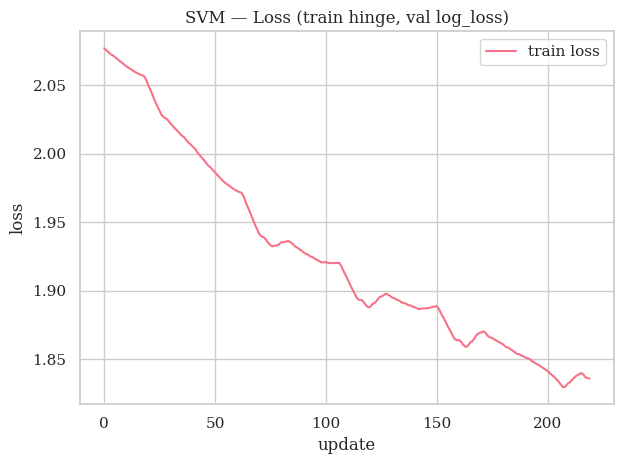

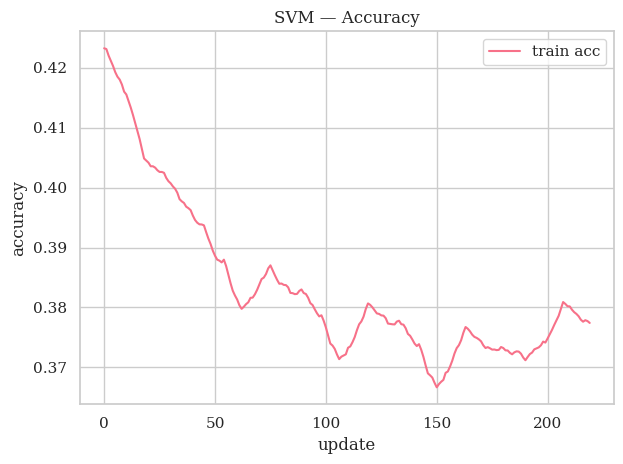

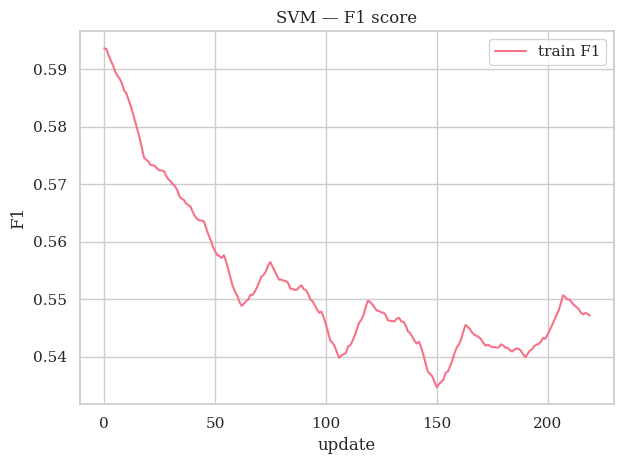

In [11]:
# after training:
plot_history(svm.history, "SVM", smooth=101)
